In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
import pandas as pd

def load_data():
    col_names = [
                 'timestamp'
                ,'street_shoe_size'
                ,'fav_sneaker_model'
                ,'foot_len'
                ,'foot_width'
                ,'foot_type'
                ,'foot_deform'
                ,'shoe_brand'
                ,'shoe_model'
                ,'shoe_model_manual'
                ,'climb_shoe_size'
                ,'shoe_age'
                ,'favourite'
                ,'vorspann'
                ,'downturn'
                ,'asymetry'
                ,'closure_type'
                ,'climb_style'
                ,'terrain'
                ,'rate_fit'
                ,'rate_comfort'
                ,'rate_stiffness'
                ,'use_frequency'
                ,'climbed_grade'
                ,'overall_rating'
                ,'gender'
                ,'height'
                ,'weight'
                ,'age'
                ,'climbing_exp'
    ]
    
    data = pd.read_csv("./data/climb_shoe_survey.csv", header=0, names=col_names)

    return data

def get_brand_per_foottype(df_survey):
    '''
    Ermittle die meist genutzte Schuhmarke pro Fußtyp
    
    :param df: DataFrame df_survey
    
    :return: Dictionary Marken sortiert nach Anzahl
    '''
    foot_types = df_survey['foot_type'].unique()
    brand_per_foottype = pd.DataFrame(columns=['foot_type', 'brand', 'count'])

    for t in foot_types:
        new_row = {'foot_type' : t, 'brand' : df_survey['shoe_brand'][df_survey['foot_type'] == t].value_counts().keys()[0], 'count' : df_survey['shoe_brand'][df_survey['foot_type'] == t].value_counts()[0]}
        brand_per_foottype = brand_per_foottype.append(new_row, ignore_index=True)

    sorted_brands = brand_per_foottype.sort_values(by='count', ascending=False)
    
    return sorted_brands

def resolve_invalid_footdeforms(df_survey): # Resolve any observation with "no deform", but typed in a deform...
    '''
    Bereinige Angaben zur Fehlstellung. Alle Beobachtungen, die sowohl Nein als auch eine weitere Angabe gemacht haben.
    
    :param df: DataFrame df_survey
    
    :return: DataFrame df
    '''

    for i in df_survey[df_survey['foot_deform'] == 'Nein, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Knickfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Knickfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß, Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Hallux Valgus, Senkfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Hallux Valgus, Senkfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Hallux Valgus'].index:
        df_survey.loc[i, 'foot_deform'] = 'Hallux Valgus'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß, Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Plattfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Plattfuß'
     
    return df_survey

def translate_values(df_survey, search_col, search_str, replace_str):
    '''
    Transformation und Bereinigung von Text. Ersetzt einen String-Wert gegen einen anderen.
    Zusätzlich wird der Wert kleingeschrieben zurückgegeben.
    
    :param df: DataFrame df_survey
    :param search_col: String relevante Spalte
    :param search_str: String Such-String
    :param replace_str: String Ersatz-String
    
    :return: DataFrame df
    '''
    df = df_survey[search_col].str.replace(search_str, replace_str).apply(lambda x: x.lower())
    return df


def resolve_invalid_foottype(df_survey, valid_foottype, false_foottype):
    '''
    Bereinige ungültige Fußtypen, z.B. Freitextangaben
    
    :param df: DataFrame df_survey
    :param col: String Spalte, die umgewandelt werden soll
    
    :return: DataFrame df_survey
    '''
    df = df_survey.apply(
        lambda row: valid_foottype
            if row.foot_type == false_foottype
          else row.foot_type, axis=1)
    return df


def generate_dummies(df_survey, col):
    '''
    Erstelle Dummy-Variablen für Spalten mit Komma-getrennten Listen als Ausprägungen
    
    :param df: DataFrame df_survey
    :param col: String Spalte, die umgewandelt werden soll
    
    :return: DataFrame df_survey
    '''
    df_survey = pd.concat([df_survey.drop(col, 1), df_survey[col].str.get_dummies(sep=", ")], 1)
    
    return df_survey

def count_deforms(df_survey): 
    '''
    Zähle pro Fehlstellung alle Vorkommnisse
    
    :param df: DataFrame df_survey
    :return: Dictionary mit sortierten Anzahlen pro Fehlstellung
    '''
    deformations = ['hallux', 'senkfuß','spreizfuß','plattfuß', 'hohlfuß','knickfuß']
    stats = {}

    for deform in deformations:
        stats.update({deform : df_survey[deform.lower().split()[0]].value_counts()[1]})
    print(stats) 
    stats_sorted = dict(sorted(stats.items(),key= lambda x:x[1]))
    
    return stats_sorted


def resolve_shoemodels(df_survey, models):
    '''
    Übernehme alle manuell eingetragenen Schuhmodelle
    
    :param df: DataFrame df_survey
    :param models: Dictionary mit Index und Schuhmodell
    
    :return: DataFrame df_survey
    '''
    for i in models:
        df_survey.loc[i,'shoe_model'] = models[i]
    return df_survey

In [73]:
# Daten laden
df_survey = load_data()

In [74]:
'''
PREPROCESSING
Daten vorbereiten
'''

# Ungültige Beobachtungen löschen
for i in df_survey[df_survey['foot_deform'] == 'Nein, abgeflachtes Quergewölbe, aber noch kein Spreizfuß'].index:
        df_survey.drop(index=i, inplace=True, axis=0)
        
df_survey.reset_index(drop=True, inplace=True)


# Daten transformieren:  - Ausprägungen für Fehlstellungen bereinigen, 
#                          wenn 'Nein' und trotzdem weitere Fehlstellungen aus gewählt wurden
#                        - Ausprägungen umbenennen
df_survey              = resolve_invalid_footdeforms(df_survey[:])
df_survey['foot_type'] = resolve_invalid_foottype(df_survey[:], 'Ägyptischer Fußtyp', 'Mix aus Römisch und Ägyptisch')
df_survey['deform']    = translate_values(df_survey[:], 'foot_deform', ' Valgus', '')
df_survey['foottype']  = translate_values(df_survey[:], 'foot_type', ' Fußtyp', '')

'''
Sonstige genannte Schuhmodelle übernehmen
'Sonstige' Schuhmodelle imputieren
'''
# Dictionary mit bekanntem Index und Schuhmodell. Dieser wird aufbereitet im Dictonary gespeichert
models = {77  : 'Boreal - SATORI',
          31  : 'Evolv - SHAMAN 2',
          86  : 'Evolv - SHAMAN 2',
          88  : 'Evolv - SHAMAN 2',
          103 : 'La Sportiva - MILLET EASY UP',
          140 : 'Red Chili - AMP',
          154 : 'Evolv - SHAMAN 2',
          155 : 'Evolv - SHAMAN 2'}

df_survey = resolve_shoemodels(df_survey[:], models)

# Ermittle das häufigste Schuhmodell einer Marke und ersetze 'Sonstige'
most_common_models = {}
    
for i in df_survey.groupby(['shoe_brand', 'shoe_model'])['shoe_model'].count().sort_values().groupby(level=0).tail(1).index:
    most_common_models.update({i[0]:i[1]})
for i in df_survey['shoe_brand'][df_survey['shoe_model'] == 'Sonstige'].index:
    df_survey.at[i,'shoe_model'] = most_common_models[df_survey['shoe_brand'].iloc[i]]

df_survey.at[18,'shoe_model'] = df_survey.at[18,'shoe_brand']

# One hot encoding von Spalten mit komma-separierten Ausprägungslisten
df_survey = generate_dummies(df_survey[:], 'deform')
df_survey = generate_dummies(df_survey[:], 'climb_style')
df_survey = generate_dummies(df_survey[:], 'terrain')
df_survey = generate_dummies(df_survey[:], 'foottype')
df_survey = pd.get_dummies(data=df_survey, columns=['gender'],drop_first=True)

'''
Ausreißer bereinigen
'''
# Fußlänge unter 20
mask = df_survey['foot_len'] < 20
df_survey.loc[mask, 'foot_len'] = round(df_survey['foot_len'].mean(),2)


df_survey.head(1)

,timestamp,street_shoe_size,fav_sneaker_model,foot_len,foot_width,foot_type,foot_deform,shoe_brand,shoe_model,shoe_model_manual,...,Bouldern,Mehrseillängen,Sportklettern,Beides,Halle,Outdoor,griechischer,römischer,ägyptischer,gender_Weiblich
0,24.02.2021 22:27:44,41.5,Vans Authentic,25.5,10.0,Ägyptischer Fußtyp,Nein,La Sportiva,La Sportiva - SKWAMA,NaN,...,1,0,1,1,0,0,0,0,1,0


In [75]:
'''
Erzeugung Dataframe mit aufbereiteten Daten für die Zuführung ins Modell-Training. 
'''
#Hier wird die Zielvariable shoe_model bereits entfernt!
df_prep = df_survey.drop(['timestamp','foot_deform','foot_type', 'fav_sneaker_model', 'shoe_brand', 'shoe_model',
       'shoe_model_manual', 'climb_shoe_size', 'shoe_age', 'favourite',
       'vorspann', 'downturn', 'asymetry', 'closure_type','rate_fit', 'rate_comfort', 'rate_stiffness',
       'use_frequency', 'climbed_grade', 'overall_rating', 'Beides', 'nein'], axis=1)
df_prep.head(1)

,street_shoe_size,foot_len,foot_width,height,weight,age,climbing_exp,fersenbein,hallux,hohlfuß,...,spreizfuß,Bouldern,Mehrseillängen,Sportklettern,Halle,Outdoor,griechischer,römischer,ägyptischer,gender_Weiblich
0,41.5,25.5,10.0,168,61,29,4.0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [76]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   street_shoe_size  181 non-null    float64
 1   foot_len          181 non-null    float64
 2   foot_width        181 non-null    float64
 3   height            181 non-null    int64  
 4   weight            181 non-null    int64  
 5   age               181 non-null    int64  
 6   climbing_exp      181 non-null    float64
 7   fersenbein        181 non-null    int64  
 8   hallux            181 non-null    int64  
 9   hohlfuß           181 non-null    int64  
 10  knickfuß          181 non-null    int64  
 11  plattfuß          181 non-null    int64  
 12  senkfuß           181 non-null    int64  
 13  spreizfuß         181 non-null    int64  
 14  Bouldern          181 non-null    int64  
 15  Mehrseillängen    181 non-null    int64  
 16  Sportklettern     181 non-null    int64  
 1

In [77]:
df_prep.shape

(181, 23)

In [78]:
''' Vorbereitung Modell-Training

1. X und y werden initialisiert
2. Daten werden skaliert
3. Dimensionen werden mittels PCA reduziert
4. Daten werden in Trainings- und Testdaten gesplittet

'''
X = df_prep
y= df_survey['shoe_model']


# Daten skalieren
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Dimensionsreduktion mittels Hauptkomponentenanalyse (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, whiten=True)
pca_features = pca.fit_transform(scaled_features)

print("Ursprüngliche Anzahl an Merkmalen:", scaled_features.shape[1])
print("Reduzierte Anzahl an Merkmalen:", pca_features.shape[1])


# Datensatz in Training- und Testdaten splitten
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Ursprüngliche Anzahl an Merkmalen: 23
Reduzierte Anzahl an Merkmalen: 17


In [79]:
X_train.shape

(121, 23)

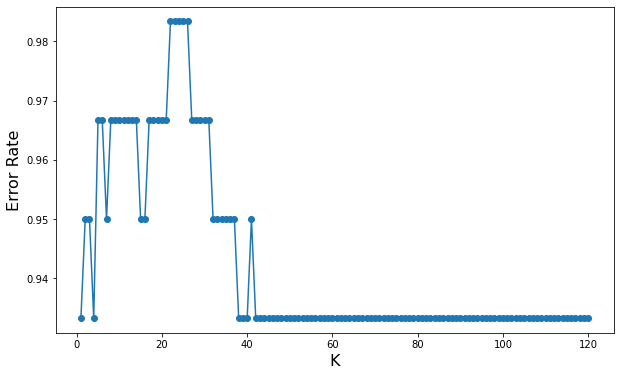

In [58]:
''' KNN-Klassifikator: K ermitteln mittels Elbow-Methode
'''
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

k_max = k_max = X_train.shape[0]

for i in range(1,k_max):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))

plt.plot(range(1,k_max), error_rate, marker='o')
plt.ylabel('Error Rate', fontsize=16)
plt.xlabel('K', fontsize=16)
plt.show()

In [80]:
''' KNN-Klassifikator: Training
'''
from sklearn.neighbors import KNeighborsClassifier

# Initialisiere K-Nearest Neighbor Classifier Objekt
knn = KNeighborsClassifier(n_neighbors=39, n_jobs=-1)

# Trainiere das Modell mit den skalierten X-Werten und füge die Trainigswerte für y hinzu
knn.fit(X_train,y_train)

# Modellbewertung mittels K-Fold Crossvalidation
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=1)

cv_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1_weighted', n_jobs=-1)

print(f"F1: {cv_results.mean()}")

F1: 0.02685185185185185


In [68]:
''' KNN-Klassifikator: Hyperparameter ermitteln mittels GridSearch
'''
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
k = 95
pipe = Pipeline([("knn", knn)])


search_space = [{"knn__n_neighbors": range(1, k), 
                 "knn__metric" : ["minkowski", "manhattan", "euclidean"], 
                 "knn__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                "knn__weights" : ['uniform', 'distance']}]

gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train, y_train)

gridsearch.best_estimator_.get_params()

C:\Users\steff\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


47

In [70]:
''' KNN-Klassifikator: Hyperparameter ermitteln mittels GridSearch
'''
from sklearn.neighbors import KNeighborsClassifier

# Initialisiere K-Nearest Neighbor Classifier Objekt
knn = KNeighborsClassifier(n_neighbors=47, n_jobs=-1, leaf_size=30, weights='distance')

# Trainiere das Modell mit den skalierten X-Werten und füge die Trainigswerte für y hinzu
knn.fit(X_train,y_train)

# Modellbewertung mittels K-Fold Crossvalidation
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=1)

cv_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1_weighted', n_jobs=-1)

print(f"F1: {cv_results.mean()}")

F1: 0.07035103785103784
